In [ ]:
#import necessary liberaries
import pandas as pd                              #for data manipulation and analysis
import numpy as np                               #for numerical operations
import cv2                                       #openCvfor computer vision tasks
import PIL                                       #python imaging library for image processing
import matplotlib.pyplot as plt                  #for creating plots and visualisations
# import plotly.express as px                      #interactive plotting library
import seaborn as sns                            #statistical data visualization
import glob                                      #for searching files using patterns
import random                                    #for generating random numbers
import os                                        #for interacting with operating system
# import pydicom
import keras.utils as image
%matplotlib inline
import tensorflow as tf
from os import listdir                               #for listing files in directory
from matplotlib.image import imread
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.model_selection  import train_test_split
from tensorflow.keras.models import load_model
import keras
from tensorflow.keras import layers
from keras_cv import models as keras_cv_models
import time
from concurrent.futures import ThreadPoolExecutor
# Display some images
import matplotlib.image as mpimg

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
#set seed for reproducibility
random.seed(100)
np.random.seed(100)


TensorFlow version: 2.16.1
Keras version: 3.3.3


In [ ]:
dicom_data = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/dicom_info.csv')
#image_dir = '/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

In [ ]:
dicom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10237 entries, 0 to 10236
Data columns (total 38 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   file_path                                    10237 non-null  object 
 1   image_path                                   10237 non-null  object 
 2   AccessionNumber                              0 non-null      float64
 3   BitsAllocated                                10237 non-null  int64  
 4   BitsStored                                   10237 non-null  int64  
 5   BodyPartExamined                             10237 non-null  object 
 6   Columns                                      10237 non-null  int64  
 7   ContentDate                                  10237 non-null  int64  
 8   ContentTime                                  10237 non-null  float64
 9   ConversionType                               10237 non-null  object 
 10

In [ ]:
# check image types in dataset
dicom_data.SeriesDescription.unique()

array(['cropped images', 'full mammogram images', nan, 'ROI mask images'],
      dtype=object)

<Axes: xlabel='SeriesDescription', ylabel='count'>

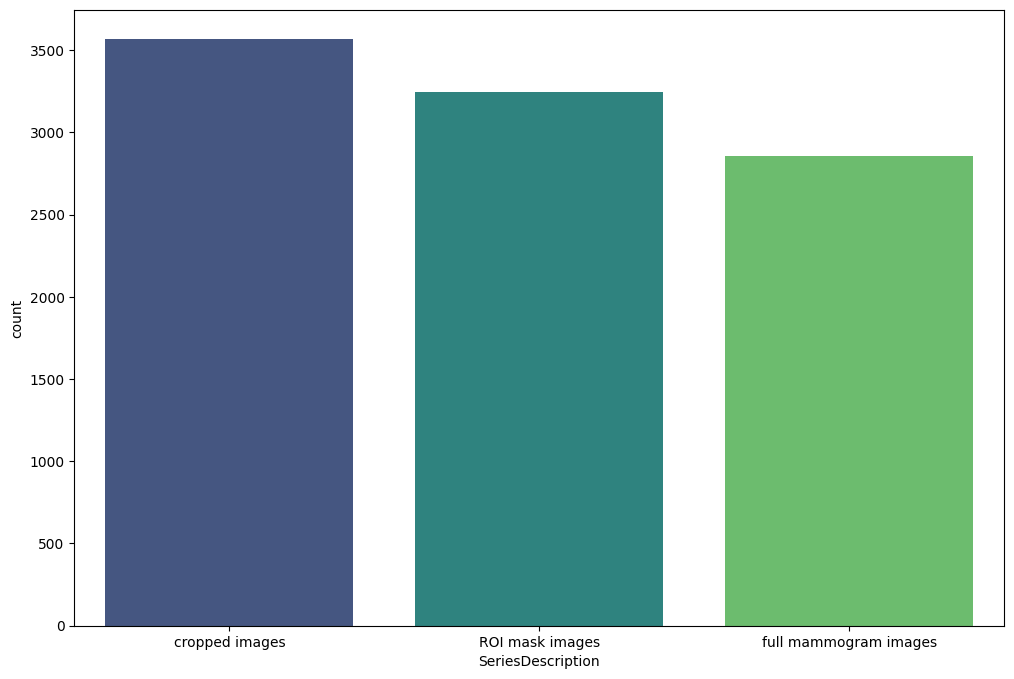

In [ ]:
plt.figure(figsize=(12,8))
sns.barplot(x=dicom_data.SeriesDescription.value_counts(dropna=False).index, y=dicom_data.SeriesDescription.value_counts(dropna=False), palette='viridis')

In [ ]:
dicom_data.head()
dicom_data.shape

(10237, 38)

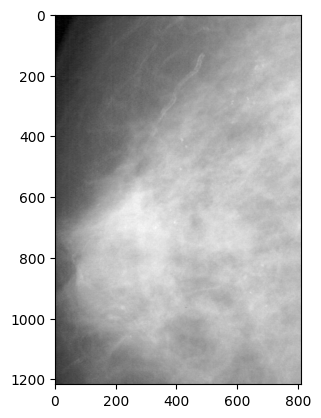

In [ ]:
# Filter 'dicom_data' DataFrame to select rows where 'SeriesDescription' is 'cropped images'
cropped_images=dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path

# Set the directory path for JPEG images
image_dir = '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg'

cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in cropped_images[0:5]:
  cropped_images_show = PIL.Image.open(file)

# Convert the image to grayscale
  gray_img= cropped_images_show.convert("L")
  plt.imshow(gray_img, cmap='gray')


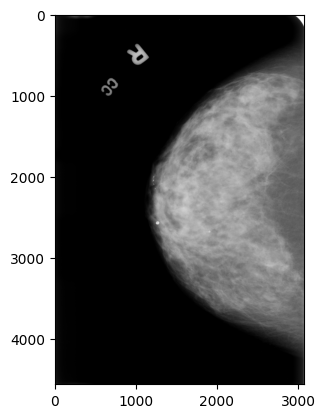

In [ ]:
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in full_mammogram_images[0:5]:
  full_mammogram_images_show = PIL.Image.open(file)
  gray_img= full_mammogram_images_show.convert("L")
  plt.imshow(gray_img, cmap='gray')


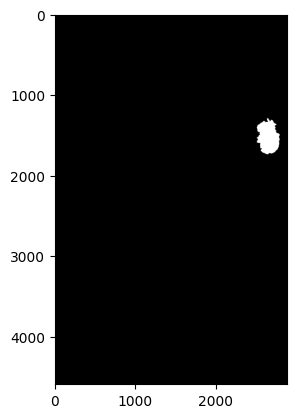

In [ ]:
ROI_mask_images=dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in ROI_mask_images[0:5]:
    # Open the image using PIL (Python Imaging Library)
  ROI_mask_images_show = PIL.Image.open(file)
  gray_img= ROI_mask_images_show.convert("L")
  plt.imshow(gray_img, cmap='gray')

In [ ]:
def cropBorders(img, l=0.01, r=0.01, u=0.04, d=0.04):

    nrows, ncols = img.shape

    # Get the start and end rows and columns
    l_crop = int(ncols * l)
    r_crop = int(ncols * (1 - r))
    u_crop = int(nrows * u)
    d_crop = int(nrows * (1 - d))

    cropped_img = img[u_crop:d_crop, l_crop:r_crop]

    return cropped_img

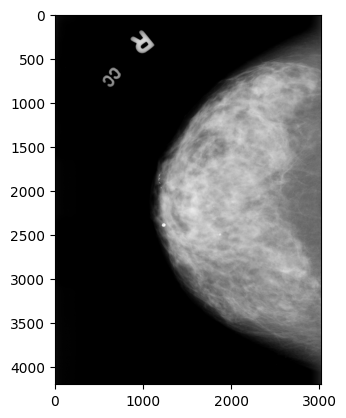

In [ ]:
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
for file  in full_mammogram_images[0:5]:
  full_mammogram_images_show = PIL.Image.open(file)
  cropped_img = cropBorders(np.array(full_mammogram_images_show))
  plt.imshow(cropped_img, cmap='gray')

In [ ]:
def minMaxNormalise(img):

    norm_img = (img - img.min()) / (img.max() - img.min())

    return norm_img

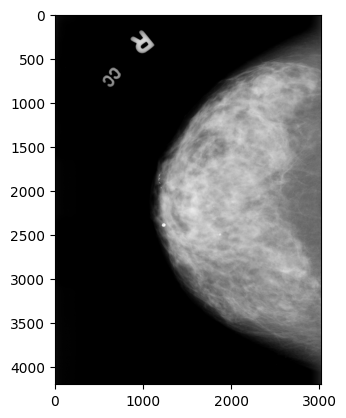

In [ ]:
normalized_img = minMaxNormalise(cropped_img)
plt.imshow(normalized_img, cmap='gray')

In [ ]:
def globalBinarise(img, thresh, maxval):

    binarised_img = np.zeros(img.shape, np.uint8)
    binarised_img[img >= thresh] = maxval

    return binarised_img

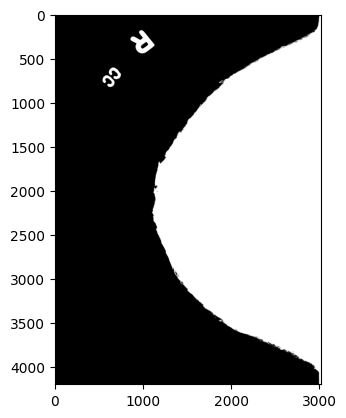

In [ ]:
binarized_img = globalBinarise(normalized_img, 0.1, 1)
plt.imshow(binarized_img, cmap='gray')

In [ ]:
def editMask(mask, ksize=(23, 23), operation="open"):

    kernel = cv2.getStructuringElement(shape=cv2.MORPH_RECT, ksize=ksize)

    if operation == "open":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    elif operation == "close":
        edited_mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    # Then dilate
    edited_mask = cv2.morphologyEx(edited_mask, cv2.MORPH_DILATE, kernel)

    return edited_mask

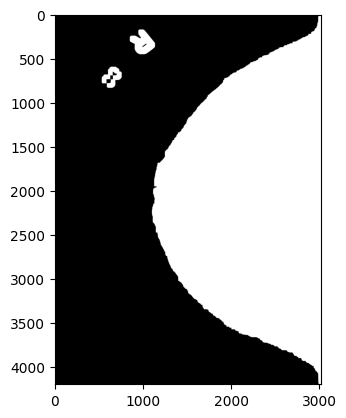

In [ ]:
masked_img = editMask(binarized_img)
plt.imshow(masked_img, cmap='gray')

In [ ]:
calc_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/calc_case_description_train_set.csv')

In [ ]:
mass_case_df = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv')
# Read CSV files into DataFrames
mass_case_test_df=pd.read_csv('../input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_test_set.csv')

In [ ]:
mass_case_df.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
mass_case_df.describe()

,breast_density,abnormality id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


In [ ]:
# check datasets shape
print(f'Shape of mass_train: {mass_case_df.shape}')
print(f'Shape of mass_test: {mass_case_test_df.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [ ]:
df_meta= pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/meta.csv')
df_meta.head()

,SeriesInstanceUID,StudyInstanceUID,Modality,SeriesDescription,BodyPartExamined,SeriesNumber,Collection,Visibility,ImageCount
0,1.3.6.1.4.1.9590.100.1.2.117041576511324414842...,1.3.6.1.4.1.9590.100.1.2.229361142710768138411...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
1,1.3.6.1.4.1.9590.100.1.2.438738396107617880132...,1.3.6.1.4.1.9590.100.1.2.195593486612988388325...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
2,1.3.6.1.4.1.9590.100.1.2.767416741131676463382...,1.3.6.1.4.1.9590.100.1.2.257901172612530623323...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
3,1.3.6.1.4.1.9590.100.1.2.296931352612305599800...,1.3.6.1.4.1.9590.100.1.2.109468616710242115222...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2
4,1.3.6.1.4.1.9590.100.1.2.436657670120353100077...,1.3.6.1.4.1.9590.100.1.2.380627129513562450304...,MG,ROI mask images,BREAST,1,CBIS-DDSM,1,2


In [ ]:
df_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6775 entries, 0 to 6774
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   SeriesInstanceUID  6775 non-null   object
 1   StudyInstanceUID   6775 non-null   object
 2   Modality           6775 non-null   object
 3   SeriesDescription  6775 non-null   object
 4   BodyPartExamined   6775 non-null   object
 5   SeriesNumber       6775 non-null   int64 
 6   Collection         6775 non-null   object
 7   Visibility         6775 non-null   int64 
 8   ImageCount         6775 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 476.5+ KB


# **Data cleaning**

In [ ]:
dicom_cleaned_data = dicom_data.copy()
dicom_cleaned_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [ ]:
dicom_cleaned_data.drop(['PatientBirthDate','AccessionNumber','Columns','ContentDate','ContentTime',
                         'PatientSex','PatientBirthDate','ReferringPhysicianName','Rows','SOPClassUID','SOPInstanceUID',
                         'StudyDate','StudyID','StudyInstanceUID','StudyTime','InstanceNumber','SeriesInstanceUID','SeriesNumber'
                        ],axis =1, inplace=True)

In [ ]:
# Let's fill the missing values in the column with the next value
dicom_cleaned_data['SeriesDescription'].ffill(inplace=True)
dicom_cleaned_data['Laterality'].bfill(inplace=True)
dicom_cleaned_data.isna().sum()

/tmp/ipykernel_36/3977537386.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  dicom_cleaned_data['SeriesDescription'].ffill(inplace=True)
/tmp/ipykernel_36/3977537386.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)

file_path                                      0
image_path                                     0
BitsAllocated                                  0
BitsStored                                     0
BodyPartExamined                               0
ConversionType                                 0
HighBit                                        0
LargestImagePixelValue                         0
Laterality                                     0
Modality                                       0
PatientID                                      0
PatientName                                    0
PatientOrientation                             0
PhotometricInterpretation                      0
PixelRepresentation                            0
SamplesPerPixel                                0
SecondaryCaptureDeviceManufacturer             0
SecondaryCaptureDeviceManufacturerModelName    0
SeriesDescription                              0
SmallestImagePixelValue                        0
SpecificCharacterSet

In [ ]:
Data_cleaning_1 = calc_case_df.copy()
# Name changes have been made in the following lines.
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc type':'calc_type'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'calc distribution':'calc_distribution'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'image view':'image_view'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'breast density':'breast_density'})
Data_cleaning_1 = Data_cleaning_1.rename(columns={'abnormality type':'abnormality_type'})

# Converts the data types in the specified columns to categorical type.
Data_cleaning_1['pathology'] = Data_cleaning_1['pathology'].astype('category')
Data_cleaning_1['calc_type'] = Data_cleaning_1['calc_type'].astype('category')
Data_cleaning_1['calc_distribution'] = Data_cleaning_1['calc_distribution'].astype('category')
Data_cleaning_1['abnormality_type'] = Data_cleaning_1['abnormality_type'].astype('category')
Data_cleaning_1['image_view'] = Data_cleaning_1['image_view'].astype('category')
Data_cleaning_1['left_or_right_breast'] = Data_cleaning_1['left_or_right_breast'].astype('category')

Data_cleaning_1.isna().sum()

patient_id                   0
breast_density               0
left_or_right_breast         0
image_view                   0
abnormality id               0
abnormality_type             0
calc_type                   20
calc_distribution          376
assessment                   0
pathology                    0
subtlety                     0
image file path              0
cropped image file path      0
ROI mask file path           0
dtype: int64

In [ ]:
calc_case_df.shape

(1546, 14)

In [ ]:
# Data filling is done again for the specified columns.
Data_cleaning_1['calc_type'].bfill(inplace=True)
Data_cleaning_1['calc_distribution'].bfill(inplace=True)
Data_cleaning_1.isna().sum()

/tmp/ipykernel_36/1272220598.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_1['calc_type'].bfill(inplace=True)
/tmp/ipykernel_36/1272220598.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usin

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
calc_type                  0
calc_distribution          0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [ ]:
# Create a copy of 'data_2_test' DataFrame for cleaning
Data_cleaning_2_test = mass_case_test_df.copy()

# Rename columns in 'Data_cleaning_2_test' DataFrame
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'image view':'image_view'})
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'abnormality type':'abnormality_type'})
# Convert specified columns in 'Data_cleaning_2_test' to the 'category' data type
Data_cleaning_2_test['left_or_right_breast'] = Data_cleaning_2_test['left_or_right_breast'].astype('category')
Data_cleaning_2_test['image_view'] = Data_cleaning_2_test['image_view'].astype('category')
Data_cleaning_2_test['mass_margins'] = Data_cleaning_2_test['mass_margins'].astype('category')
Data_cleaning_2_test['mass_shape'] = Data_cleaning_2_test['mass_shape'].astype('category')
Data_cleaning_2_test['abnormality_type'] = Data_cleaning_2_test['abnormality_type'].astype('category')
Data_cleaning_2_test['pathology'] = Data_cleaning_2_test['pathology'].astype('category')
# Display the count of missing values in each column of 'Data_cleaning_2_test' DataFrame
Data_cleaning_2_test.isna().sum()
# Fill missing values in 'mass_margins' column of 'Data_cleaning_2_test' DataFrame using backward fill
Data_cleaning_2_test['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
# Display the count of missing values in each column of 'Data_cleaning_2' DataFrame
Data_cleaning_2_test.isna().sum()

/tmp/ipykernel_36/860781911.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_2_test['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)
/tmp/ipykernel_36/860781911.py:20: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  Data_cleaning_2_test['mass_margins'].fillna(method = 'bfill', axis = 0, inplace=True)


patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [ ]:
Data_cleaning_2 = mass_case_df.copy()
# change name
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass shape':'mass_shape'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast':'left_or_right_breast'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'mass margins':'mass_margins'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'image view':'image_view'})
Data_cleaning_2 = Data_cleaning_2.rename(columns={'abnormality type':'abnormality_type'})
#Changing the data type
Data_cleaning_2['left_or_right_breast'] = Data_cleaning_2['left_or_right_breast'].astype('category')
Data_cleaning_2['image_view'] = Data_cleaning_2['image_view'].astype('category')
Data_cleaning_2['mass_margins'] = Data_cleaning_2['mass_margins'].astype('category')
Data_cleaning_2['mass_shape'] = Data_cleaning_2['mass_shape'].astype('category')
Data_cleaning_2['abnormality_type'] = Data_cleaning_2['abnormality_type'].astype('category')
Data_cleaning_2['pathology'] = Data_cleaning_2['pathology'].astype('category')
Data_cleaning_2.isna().sum()

patient_id                  0
breast_density              0
left_or_right_breast        0
image_view                  0
abnormality id              0
abnormality_type            0
mass_shape                  4
mass_margins               43
assessment                  0
pathology                   0
subtlety                    0
image file path             0
cropped image file path     0
ROI mask file path          0
dtype: int64

In [ ]:
# Let's fill in the blank data
Data_cleaning_2['mass_shape'].bfill(inplace=True)
Data_cleaning_2['mass_margins'].bfill(inplace=True)
Data_cleaning_2.isna().sum()

/tmp/ipykernel_36/3678976608.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  Data_cleaning_2['mass_shape'].bfill(inplace=True)
/tmp/ipykernel_36/3678976608.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

patient_id                 0
breast_density             0
left_or_right_breast       0
image_view                 0
abnormality id             0
abnormality_type           0
mass_shape                 0
mass_margins               0
assessment                 0
pathology                  0
subtlety                   0
image file path            0
cropped image file path    0
ROI mask file path         0
dtype: int64

In [ ]:
# Create a DataFrame with counts of unique values in 'SeriesDescription' column
r= pd.DataFrame(dicom_cleaned_data['SeriesDescription'].value_counts())
# Reset the index to have 'SeriesDescription' as a column
r= r.reset_index()
# Rename columns for clarity
r= r.rename(columns={'SeriesDescription':'SeriesDescription_counts', 'index':'SeriesDescription'})
# Display the DataFrame
r

,SeriesDescription_counts,count
0,cropped images,3843
1,ROI mask images,3362
2,full mammogram images,3032


In [ ]:
# Print the original column names in Data_cleaning_2 DataFrame
print(Data_cleaning_2.columns)
print('\n')
# Rename selected columns in Data_cleaning_2 DataFrame for better clarity
Data_cleaning_2 = Data_cleaning_2.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

# Display the updated column names in Data_cleaning_2 DataFrame



Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




In [ ]:
# Print the original column names in Data_cleaning_2_test DataFrame
print(Data_cleaning_2_test.columns)
print('\n')
# Rename selected columns in Data_cleaning_2_test DataFrame for better clarity
Data_cleaning_2_test = Data_cleaning_2_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

# Display the updated column names in Data_cleaning_2_test DataFrame
Data_cleaning_2_test.columns

Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image file path',
       'cropped image file path', 'ROI mask file path'],
      dtype='object')




Index(['patient_id', 'breast_density', 'left_or_right_breast', 'image_view',
       'abnormality_id', 'abnormality_type', 'mass_shape', 'mass_margins',
       'assessment', 'pathology', 'subtlety', 'image_file_path',
       'cropped_image_file_path', 'ROI_mask_file_path'],
      dtype='object')

In [ ]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()
# Iterate through full_mammogram_images and create a dictionary with keys based on unique identifiers
for dicom in full_mammogram_images:
    key = dicom.split("/")[4]
    full_mammo_dict[key] = dicom
# Iterate through cropped_images and create a dictionary with keys based on unique identifiers
for dicom in cropped_images:
    key = dicom.split("/")[4]
    cropped_images_dict[key] = dicom
# Iterate through ROI_mask_images and create a dictionary with keys based on unique identifiers

for dicom in ROI_mask_images:
    key = dicom.split("/")[4]
    roi_img_dict[key] = dicom

# Display the keys of the first item in full_mammo_dict
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '../input/cbis-ddsm-breast-cancer-image-dataset/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [ ]:
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
        img_name = img[13].split("/")[2]
        data.iloc[index,13] = roi_img_dict[img_name]
# apply to datasets
fix_image_path(Data_cleaning_2)
fix_image_path(Data_cleaning_2_test)

In [ ]:
Data_cleaning_2.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...,../input/cbis-ddsm-breast-cancer-image-dataset...


# Visualization

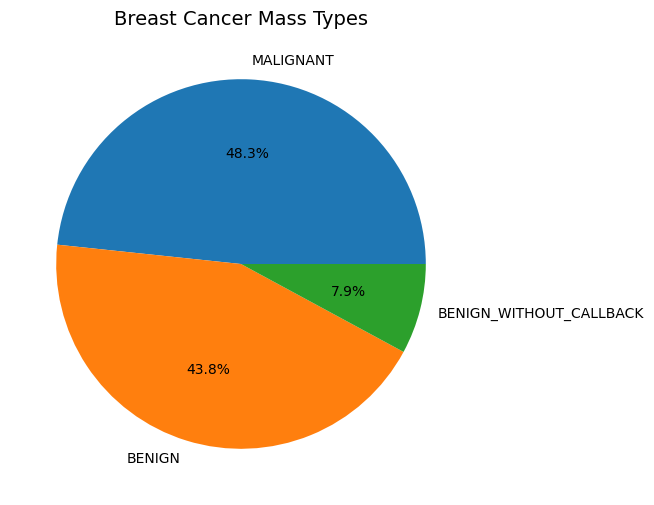

In [ ]:
# pathology distributions
value = Data_cleaning_2['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Breast Cancer Mass Types', fontsize=14)
plt.savefig('/kaggle/working/pathology_distributions_red.png')
plt.show()

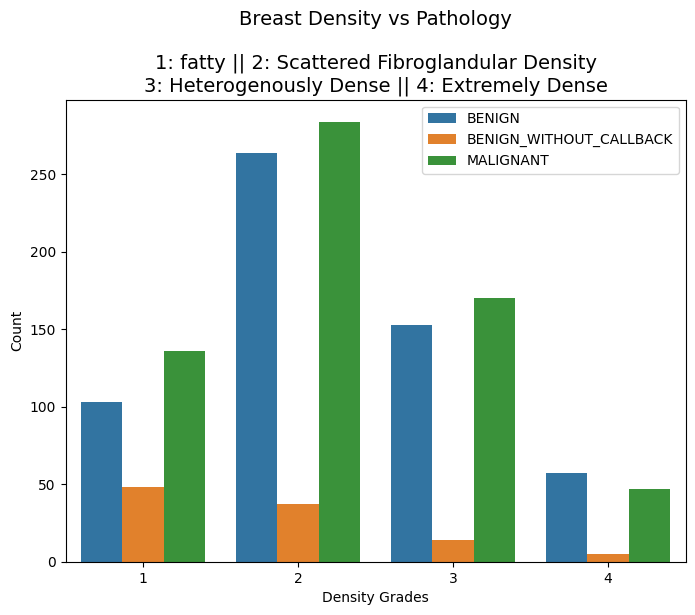

In [ ]:
# breast density against pathology
plt.figure(figsize=(8,6))

sns.countplot(Data_cleaning_2, x='breast_density', hue='pathology')
plt.title('Breast Density vs Pathology\n\n1: fatty || 2: Scattered Fibroglandular Density\n3: Heterogenously Dense || 4: Extremely Dense',
          fontsize=14)
plt.xlabel('Density Grades')
plt.ylabel('Count')
plt.legend()
plt.savefig('/kaggle/working/density_pathology_red.png')
plt.show()

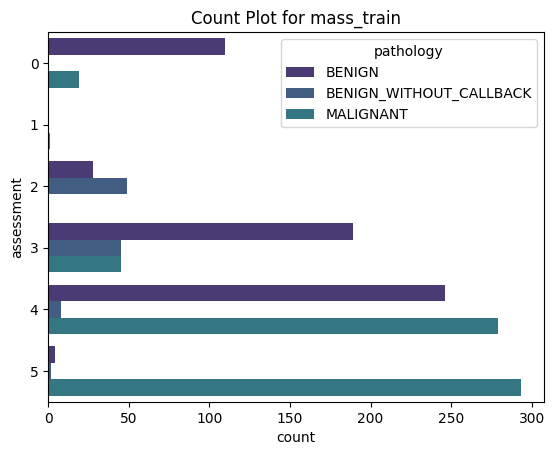

In [ ]:
# Set the color palette for mass_train
mass_palette = sns.color_palette("viridis", n_colors=len(mass_case_df['assessment'].unique()))
sns.countplot(data=Data_cleaning_2, y='assessment', hue='pathology', palette=mass_palette)
plt.title('Count Plot for mass_train')
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


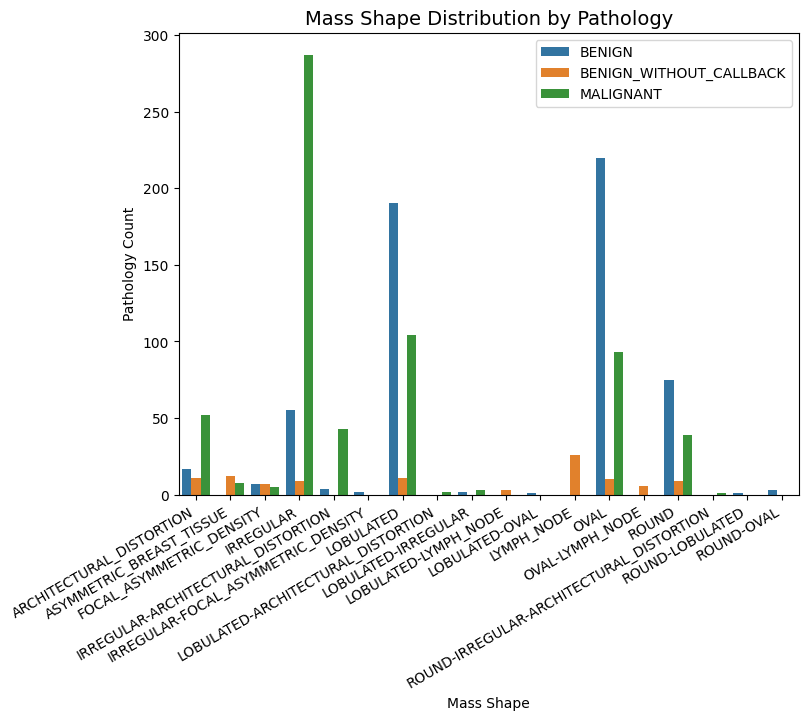

In [ ]:
# view breast mass shape distribution against pathology
plt.figure(figsize=(8,6))

sns.countplot(Data_cleaning_2, x='mass_shape', hue='pathology')
plt.title('Mass Shape Distribution by Pathology', fontsize=14)
plt.xlabel('Mass Shape')
plt.xticks(rotation=30, ha='right')
plt.ylabel('Pathology Count')
plt.legend()
plt.show()

There are 1318 rows and 14 columns


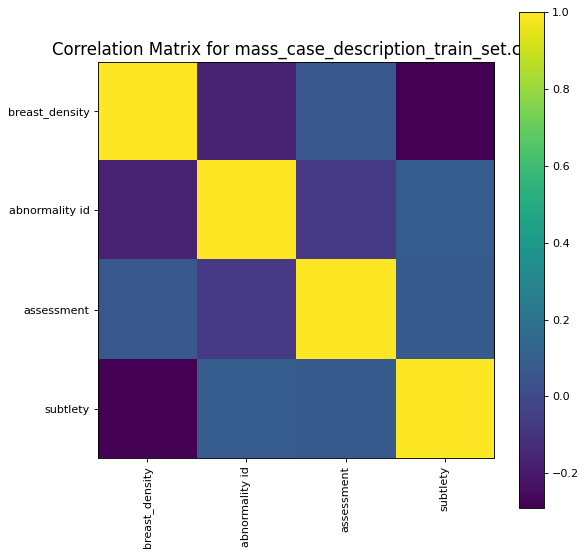

mass_case_description_train_csv


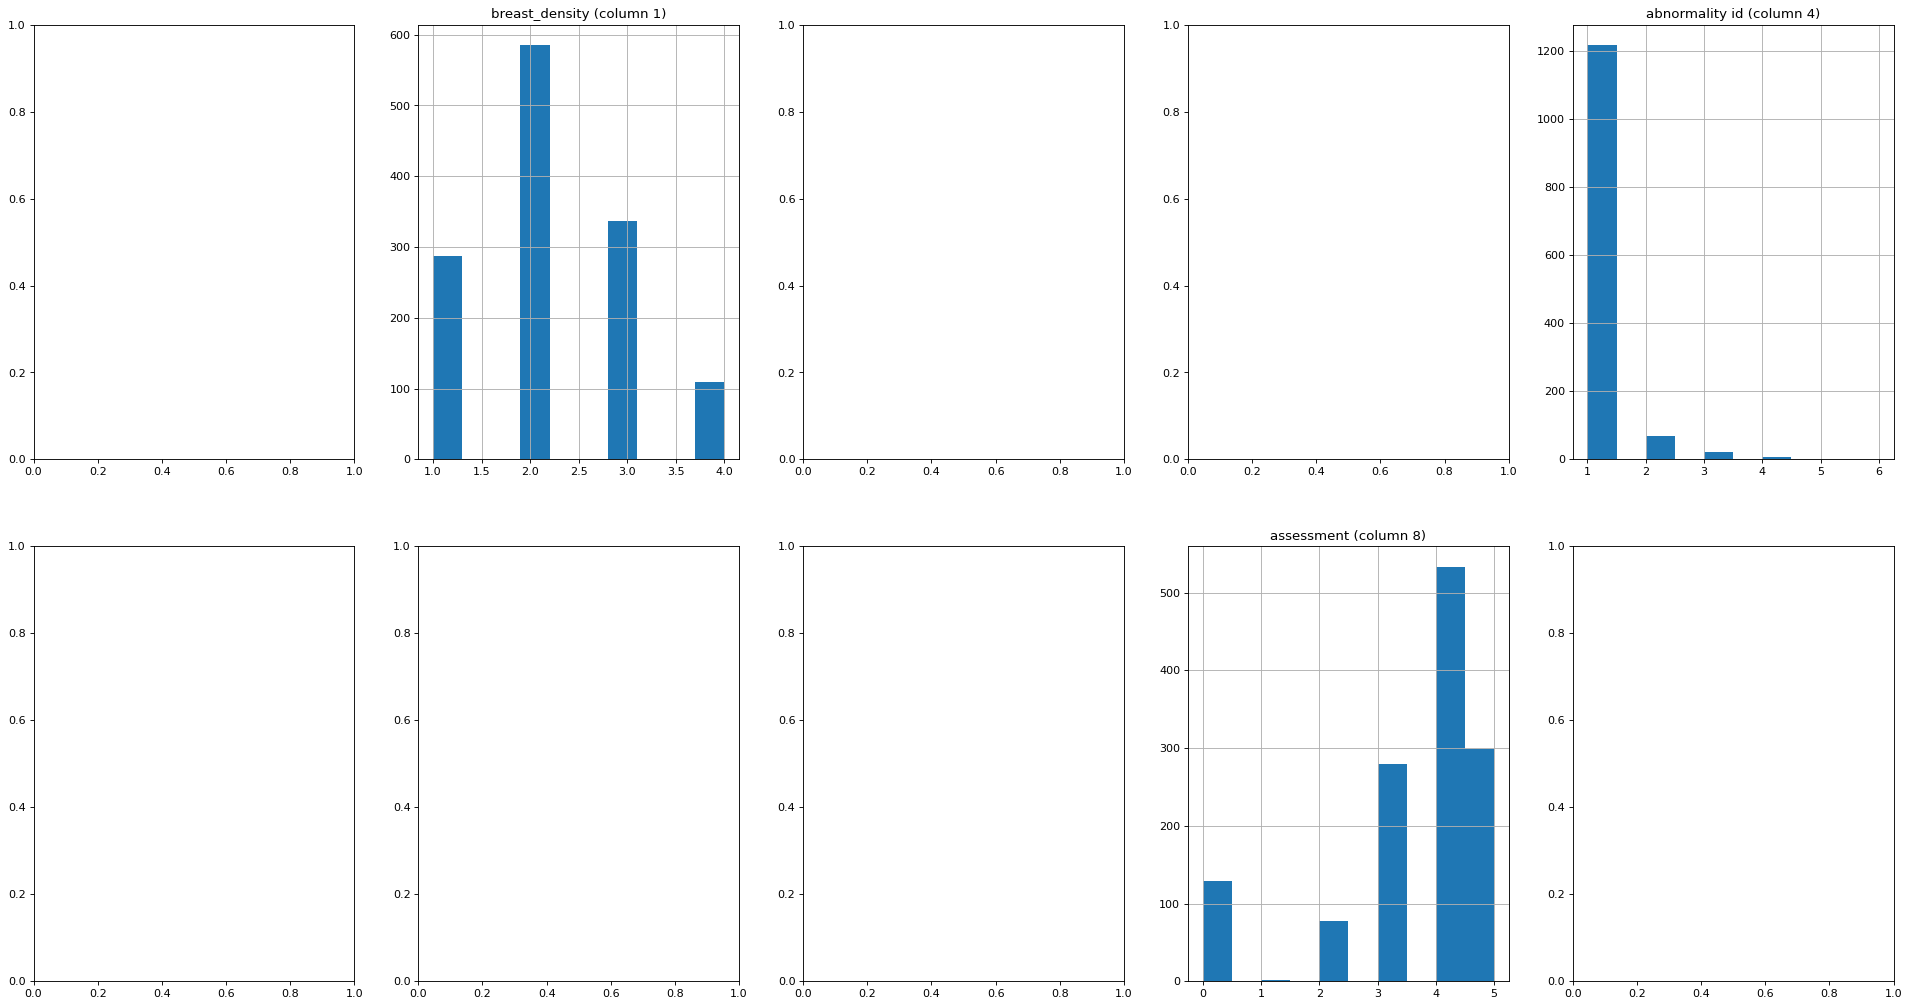

In [ ]:
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName

    # Sadece sayısal değerlere sahip sütunları seç
    numeric_df = df.select_dtypes(include=['float64', 'int64'])

    # NaN değerlere sahip sütunları temizle
    numeric_df = numeric_df.dropna(axis='columns')

    # Sadece bir sütun varsa hata mesajı göster ve fonksiyondan çık
    if numeric_df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({numeric_df.shape[1]}) is less than 2')
        return

    # Korelasyon matrisini hesapla
    corr = numeric_df.corr()

    # Matrisi görselleştir
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int(np.ceil(nCol / nGraphPerRow))

    plt.figure(num=None, figsize=(6 * nGraphPerRow, 8 * nGraphRow), dpi=80, facecolor='w', edgecolor='k')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if not np.issubdtype(type(columnDf.iloc[0]), np.number):
            continue  # Sayısal olmayan sütunları atla
        columnDf.hist()
        plt.title(f'{columnNames[i]} (column {i})')

    plt.show()




nRowsRead = 10000 # specify 'None' if want to read whole file
# mass_case_description_train_set.csv may have more rows in reality, but we are only loading/previewing the first 1000 rows
df3 = pd.read_csv('/kaggle/input/cbis-ddsm-breast-cancer-image-dataset/csv/mass_case_description_train_set.csv', delimiter=',', nrows = nRowsRead)
df3.dataframeName = 'mass_case_description_train_set.csv'
nRow, nCol = df3.shape
print(f'There are {nRow} rows and {nCol} columns')
plotCorrelationMatrix(df3, 8)
print("mass_case_description_train_csv")
plotPerColumnDistribution(df3, 10, 5)